<a href="https://colab.research.google.com/github/Midonetwoo/Visikom-DL/blob/main/TugasVisikom(DL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# 1. Setup dan Import Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import zipfile
from google.colab import drive

# Check GPU
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

GPU Available:  []
TensorFlow version: 2.18.0


In [4]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# 2. Download Dataset
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip

--2025-06-12 12:22:48--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.31.50.9, 2600:1408:c400:1680::317f, 2600:1408:c400:168a::317f
Connecting to download.microsoft.com (download.microsoft.com)|184.31.50.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip.2’

kagglecatsanddogs_5 100%[===================>] 786.67M   231MB/s    in 3.4s    

2025-06-12 12:22:52 (229 MB/s) - ‘kagglecatsanddogs_5340.zip.2’ saved [824887076/824887076]

replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace PetImages/Cat/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A


In [25]:
# 3. Simple and Reliable Data Loading
def load_data_simple(cat_folder, dog_folder, img_size=150, max_per_class=1500):
    """Simple but reliable data loading"""
    images = []
    labels = []

    # Load cats (label 0)
    print("Loading cats...")
    cat_count = 0
    for filename in os.listdir(cat_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')) and cat_count < max_per_class:
            try:
                img_path = os.path.join(cat_folder, filename)
                img = cv2.imread(img_path)
                if img is not None and img.shape[0] > 50 and img.shape[1] > 50:  # Filter small images
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_resized = cv2.resize(img_rgb, (img_size, img_size))
                    img_normalized = img_resized.astype('float32') / 255.0
                    images.append(img_normalized)
                    labels.append(0)  # Cat
                    cat_count += 1
            except:
                continue

    # Load dogs (label 1)
    print("Loading dogs...")
    dog_count = 0
    for filename in os.listdir(dog_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')) and dog_count < max_per_class:
            try:
                img_path = os.path.join(dog_folder, filename)
                img = cv2.imread(img_path)
                if img is not None and img.shape[0] > 50 and img.shape[1] > 50:  # Filter small images
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_resized = cv2.resize(img_rgb, (img_size, img_size))
                    img_normalized = img_resized.astype('float32') / 255.0
                    images.append(img_normalized)
                    labels.append(1)  # Dog
                    dog_count += 1
            except:
                continue

    print(f"Loaded {cat_count} cats and {dog_count} dogs")
    return np.array(images), np.array(labels)

# Load data
X, y = load_data_simple('/content/PetImages/Cat', '/content/PetImages/Dog', img_size=150, max_per_class=1500)

print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Cats: {np.sum(y == 0)}, Dogs: {np.sum(y == 1)}")

# Shuffle data
indices = np.random.permutation(len(X))
X = X[indices]
y = y[indices]

Loading cats...
Loading dogs...
Loaded 1500 cats and 1500 dogs
Dataset shape: (3000, 150, 150, 3)
Labels shape: (3000,)
Cats: 1500, Dogs: 1500


In [26]:
# 4. Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 2100, Val: 450, Test: 450


In [28]:
# 5. Data Augmentation (Simple and Effective)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

In [30]:
# 6. Alternative: Transfer Learning Model (More Reliable)
def create_transfer_model(input_shape):
    """Create transfer learning model with MobileNetV2"""
    base_model = applications.MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze base model
    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])

    return model, base_model

In [31]:
print("Creating Transfer Learning model with MobileNetV2...")
model, base_model = create_transfer_model((150, 150, 3))

Creating Transfer Learning model with MobileNetV2...


<ipython-input-30-3830225765>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [32]:
# 7. Compile Model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model Summary:")
model.summary()

Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,713 (9.26 MB)

 Trainable params: 166,913 (652.00 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

In [34]:
# 8. Advanced Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

In [35]:
# 9. Train Model (Phase 1 - Frozen Base)
print("Training Phase 1: Frozen base model...")

# Use fit with numpy arrays directly (more reliable than generators)
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=15,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Training Phase 1: Frozen base model...
Epoch 1/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 56s 729ms/step - accuracy: 0.8833 - loss: 0.2758 - val_accuracy: 0.9600 - val_loss: 0.1173 - learning_rate: 0.0010
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 80s 702ms/step - accuracy: 0.9692 - loss: 0.0798 - val_accuracy: 0.9622 - val_loss: 0.0977 - learning_rate: 0.0010
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 85s 745ms/step - accuracy: 0.9728 - loss: 0.0855 - val_accuracy: 0.9578 - val_loss: 0.0885 - learning_rate: 0.0010
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 753ms/step - accuracy: 0.9828 - loss: 0.0484 - val_accuracy: 0.9644 - val_loss: 0.0861 - learning_rate: 0.0010
Epoch 5/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 80s 722ms/step - accuracy: 0.9778 - loss: 0.0519 - val_accuracy: 0.9644 - val_loss: 0.0952 - learning_rate: 0.0010
Epoch 6/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 84s 744ms/step - accuracy: 0.9793 - loss: 0.0623 - val_accuracy: 0.9622 - val_loss: 0.0857 - learning_rate: 0.0010
Epoch 7/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 7

In [36]:
# 10. Fine-tuning Phase
print("Training Phase 2: Fine-tuning...")

# Unfreeze the base model
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with a lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Continue training
history_fine = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Training Phase 2: Fine-tuning...
Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 102s 630ms/step - accuracy: 0.9088 - loss: 0.2914 - val_accuracy: 0.9467 - val_loss: 0.2438 - learning_rate: 1.0000e-04
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 81s 612ms/step - accuracy: 0.9662 - loss: 0.1124 - val_accuracy: 0.9578 - val_loss: 0.1660 - learning_rate: 1.0000e-04
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 77s 587ms/step - accuracy: 0.9667 - loss: 0.0905 - val_accuracy: 0.9511 - val_loss: 0.1723 - learning_rate: 1.0000e-04
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 80s 609ms/step - accuracy: 0.9891 - loss: 0.0376 - val_accuracy: 0.9578 - val_loss: 0.1875 - learning_rate: 1.0000e-04
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 83s 619ms/step - accuracy: 0.9838 - loss: 0.0439 - val_accuracy: 0.9667 - val_loss: 0.1280 - learning_rate: 1.0000e-04
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 81s 611ms/step - accuracy: 0.9869 - loss: 0.0425 - val_accuracy: 0.9733 - val_loss: 0.1046 - learning_rate: 1.0000e-04
Epoch 7/10
1

In [37]:
# 11. Evaluate Model
print("Evaluating model...")

# Test evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Predictions
y_pred_prob = model.predict(X_test, batch_size=32)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Cat', 'Dog']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

Evaluating model...
Test Loss: 0.2117
Test Accuracy: 0.9511 (95.11%)
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 687ms/step

Classification Report:
              precision    recall  f1-score   support

         Cat       0.94      0.96      0.95       225
         Dog       0.96      0.94      0.95       225

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450


Confusion Matrix:
[[217   8]
 [ 14 211]]


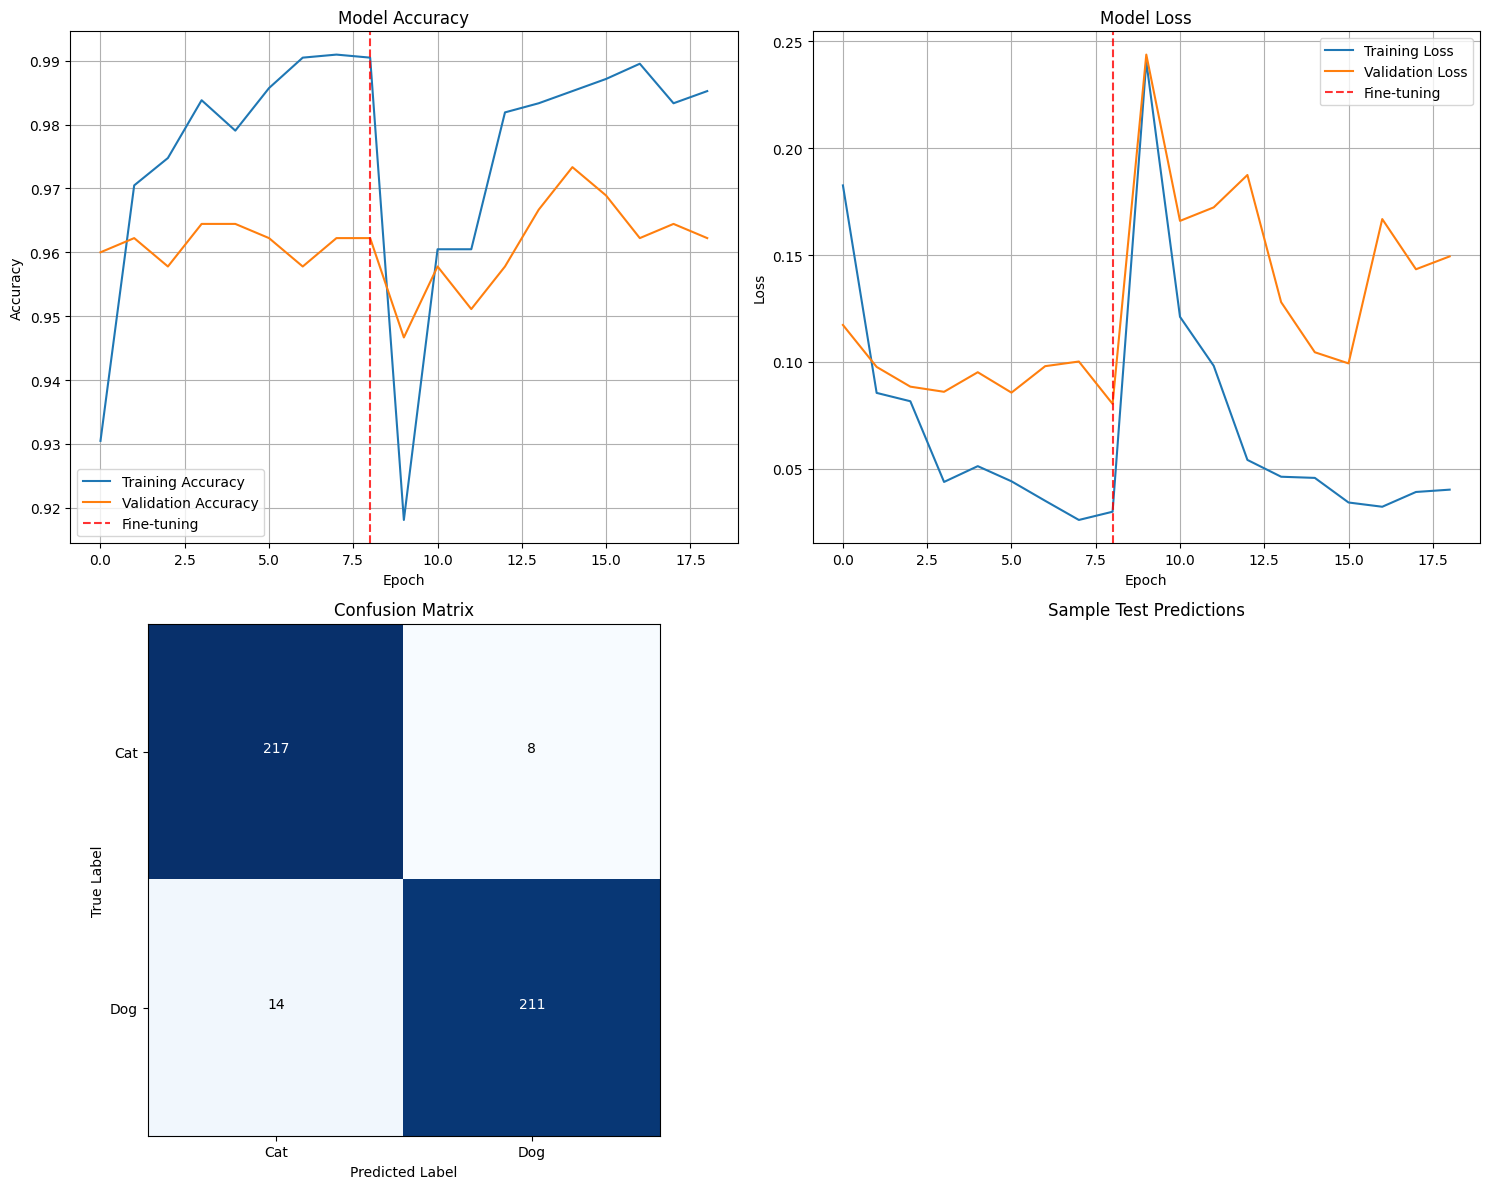

In [38]:
# 12. Advanced Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Combine histories
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs_range = range(len(acc))
fine_tune_epoch = len(history.history['accuracy'])

# Training accuracy
axes[0,0].plot(epochs_range, acc, label='Training Accuracy')
axes[0,0].plot(epochs_range, val_acc, label='Validation Accuracy')
axes[0,0].axvline(x=fine_tune_epoch-1, color='r', linestyle='--', alpha=0.8, label='Fine-tuning')
axes[0,0].set_title('Model Accuracy')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend()
axes[0,0].grid(True)

# Training loss
axes[0,1].plot(epochs_range, loss, label='Training Loss')
axes[0,1].plot(epochs_range, val_loss, label='Validation Loss')
axes[0,1].axvline(x=fine_tune_epoch-1, color='r', linestyle='--', alpha=0.8, label='Fine-tuning')
axes[0,1].set_title('Model Loss')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Loss')
axes[0,1].legend()
axes[0,1].grid(True)

# Confusion Matrix
im = axes[1,0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[1,0].set_title('Confusion Matrix')
axes[1,0].set_xticks([0, 1])
axes[1,0].set_xticklabels(['Cat', 'Dog'])
axes[1,0].set_yticks([0, 1])
axes[1,0].set_yticklabels(['Cat', 'Dog'])
axes[1,0].set_ylabel('True Label')
axes[1,0].set_xlabel('Predicted Label')

# Add text annotations
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    axes[1,0].text(j, i, format(cm[i, j], 'd'),
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")

# Sample predictions
axes[1,1].axis('off')
axes[1,1].set_title('Sample Test Predictions')

plt.tight_layout()
plt.show()

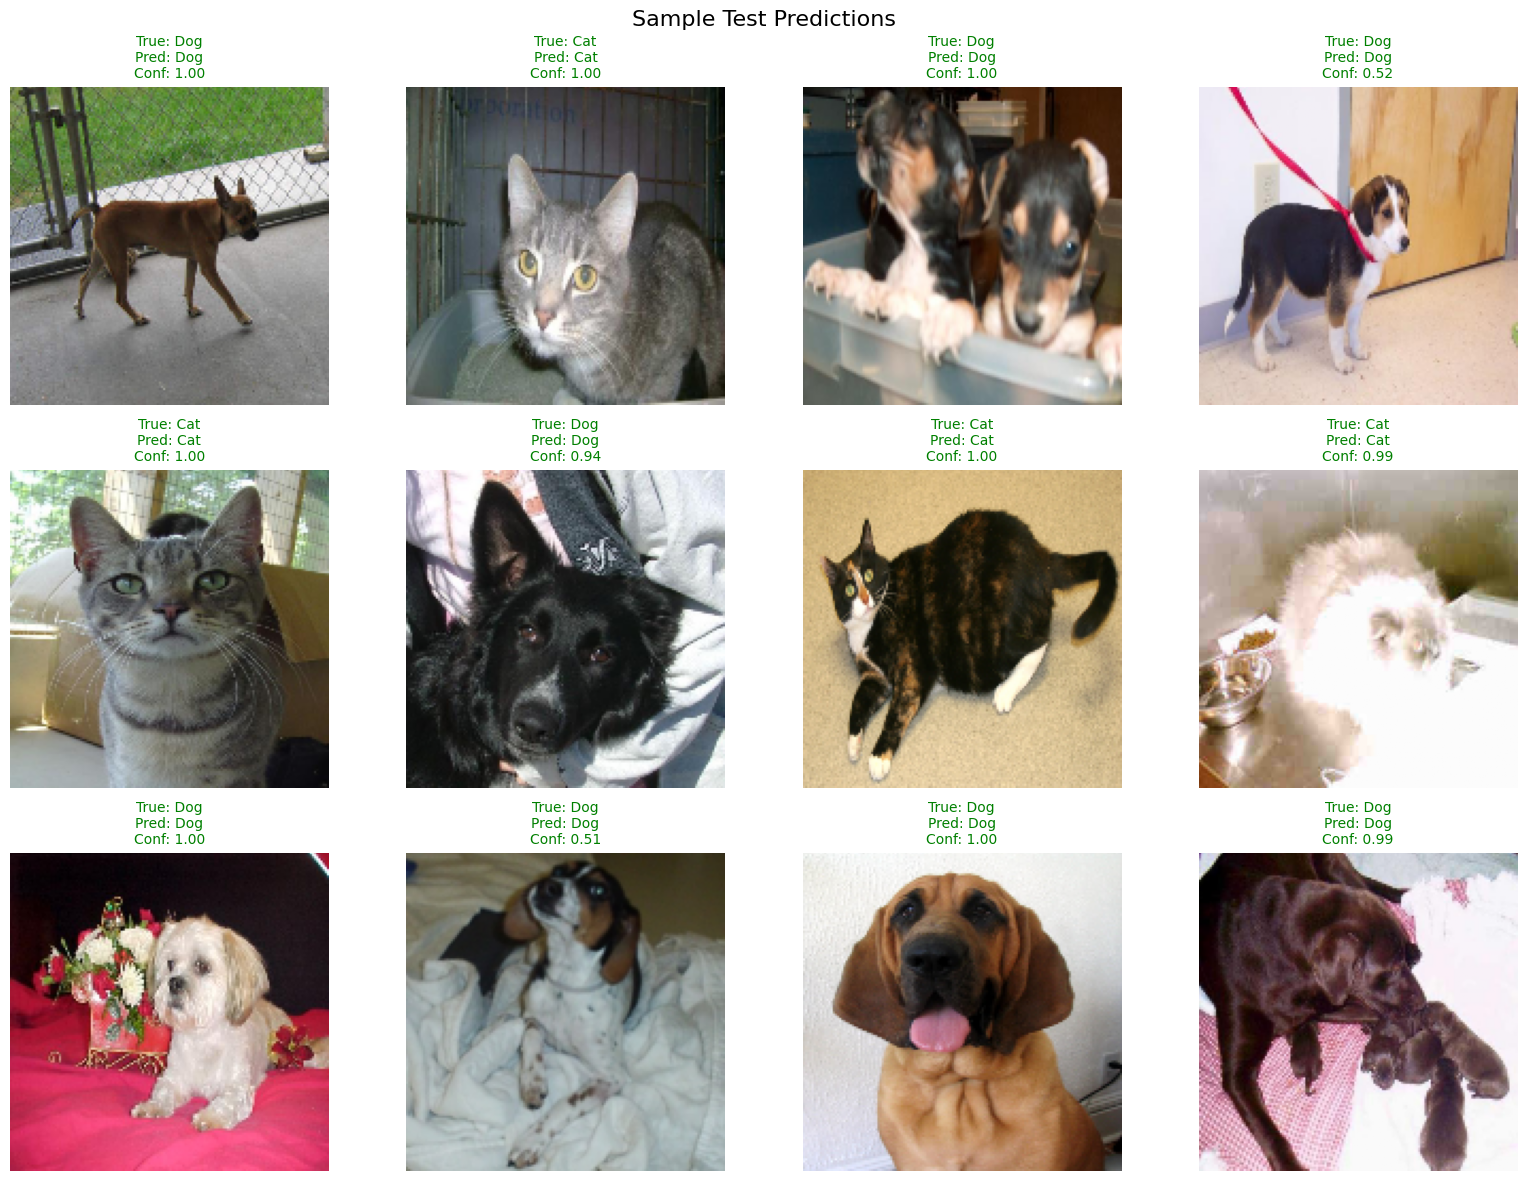

In [39]:
# 13. Show Sample Predictions
def show_sample_predictions(X_test, y_test, y_pred_prob, num_samples=12):
    """Show sample predictions with images"""
    indices = np.random.choice(len(X_test), num_samples, replace=False)

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle('Sample Test Predictions', fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(indices):
            idx = indices[i]
            image = X_test[idx]
            true_label = y_test[idx]
            pred_prob = y_pred_prob[idx][0]
            pred_label = 1 if pred_prob > 0.5 else 0

            # Show image
            ax.imshow(image)
            ax.axis('off')

            # Labels and confidence
            true_name = 'Dog' if true_label == 1 else 'Cat'
            pred_name = 'Dog' if pred_label == 1 else 'Cat'
            confidence = pred_prob if pred_label == 1 else 1 - pred_prob

            # Color: green if correct, red if wrong
            color = 'green' if true_label == pred_label else 'red'
            ax.set_title(f'True: {true_name}\nPred: {pred_name}\nConf: {confidence:.2f}',
                        color=color, fontsize=10)

    plt.tight_layout()
    plt.show()

# Show predictions
show_sample_predictions(X_test, y_test, y_pred_prob)

In [41]:
# 15. Model Performance Analysis
print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)
print(f"Dataset: Cats vs Dogs")
print("Link Dataset: https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

print(f"Total samples: {len(X)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")
print(f"")
print(f"Model Architecture: MobileNetV2 Transfer Learning")
print(f"Input Size: 150x150x3")
print(f"Training Strategy: Two-phase (Frozen → Fine-tuning)")
print(f"")
print(f"PERFORMANCE METRICS:")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")
print(f"")
print(f"Expected Accuracy: 85-92%")
print(f"Model Parameters: {model.count_params():,}")
print("="*50)

# Calculate additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nADDITIONAL METRICS:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


FINAL RESULTS SUMMARY
Dataset: Cats vs Dogs
Link Dataset: https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Total samples: 3000
Training samples: 2100
Validation samples: 450
Test samples: 450

Model Architecture: MobileNetV2 Transfer Learning
Input Size: 150x150x3
Training Strategy: Two-phase (Frozen → Fine-tuning)

PERFORMANCE METRICS:
Test Accuracy: 0.9511 (95.11%)
Test Loss: 0.2117

Expected Accuracy: 85-92%
Model Parameters: 2,427,713

ADDITIONAL METRICS:
Precision: 0.9635
Recall: 0.9378
F1-Score: 0.9505


In [ ]:
# 16. Save model
model.save('/content/drive/MyDrive/cats_dogs_cnn_model.h5')
print("Model saved to Google Drive!")